## Need-To-Do

- Analyze how much of a difference recoded transfers make?
- Properly characterize missingness based on dropped discharge dates
- Properly characterize amount of data loss with each cohort change
- ~~Remove patients with no demographic information -- detectable by a null age~~

Shape of final table:

| ruid | visit_id | admit_date | discharge_date | hospital_day | n_transfers | stay_length | readmit_time | readmit_30d |
|------|----------|------------|----------------|--------------|-------------|-------------|--------------|-------------|
| user id | hospital stay # | date admitted | date discharged | date in hospital | number of transfers | duration of stay | time from last discharge to this admission | was the patient a 30d readmit? |


## Nice-To-Do

- Construct missing discharge/admit dates from CPT codes -- do not do this for events where both are missing as these may be ER visits w/o admit, but do check if they fall in the range of an existing stay
- Characterize the amount of missingness of entire hospital visits from CPT codes

## To-do list
* Some cohort exploration based on deletion of subjects

* Look at variable correlations & clustering (if possible) -- suspect eg that systolic/diastolic will cluster based on prev work & means we can get away with using a variable score or one but not the other

* Model checking!!

**Noted:**
* labs need transformation
* meds can't be used; too sparse (though try exposure variables)
* everything else should be good
* use impute.ipynb to do variable reduction/selection

## For a general modeling pipeline:
Need a utility function that:
1. ~~Takes a DF and a list of variables,~~
2. ~~Makes a GLM and samples from it,~~
3. ~~Returns the trace & the model.~~

This will create a bunch of models & traces to check model diagnostics on, LOO, WAIC, etc & pick some "good" models.

Then need utility functions for:
1. Plotting chosen diagnostics.
2. Doing model comparisons using WAIC/LOO.
3. Measuring the accuracy vs validation set -- this will require refitting the model & using sample_ppc w/ shared theano variables to predict off the validation set.

FINALLY, take the best model that pops out of the above & refit it with both train+validation sets, then use it to predict the test set as final check of accuracy.

In [20]:
import pandas as pd
import numpy as np

preds = pd.DataFrame({'0': [1,0,1,1,0,1], '1': [1,0,0,0,1,1], '2': [1,1,1,1,1,1]})
preds

,0,1,2
0,1,1,1
1,0,0,1
2,1,0,1
3,1,0,1
4,0,1,1
5,1,1,1


In [352]:
pm.summary(simple_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-0.900067,0.029142,0.000454,-0.956491,-0.842886,3401.717371,0.999861
age,-0.228490,0.020128,0.000323,-0.267020,-0.187567,3882.370796,0.999753
sex,-0.078536,0.041761,0.000561,-0.153841,0.008811,3768.455750,0.999810
bmi_last,-0.028664,0.034157,0.000784,-0.100935,0.028140,2014.785287,0.999750
pregnancy_indicator_last,-1.115517,0.116594,0.002193,-1.354513,-0.893207,3577.625644,0.999908


In [21]:
y_true = [0,1,1,0,0,1]

In [46]:
pred_correct = preds == y_true
pred_pos = preds == 1 
pred_neg = preds == 0
true_pos = np.sum(pred_correct & pred_pos,axis = 0)
all_pos = np.sum(pred_pos, axis = 0)
n_cases = np.sum(y_true)

In [39]:
all_pos

0    4
1    3
2    6
dtype: int64

In [53]:
recall = (true_pos/n_cases).mean()
precision = (true_pos/all_pos).mean()
f1 = 2*(precision*recall)/(precision+recall)
accuracy = np.mean(pred_correct.mean(axis = 0))

In [54]:
f1

0.5333333333333333

In [1]:
from pymc3 import sample

In [2]:
sample?

Signature:
sample(
    ['draws=500', 'step=None', "init='auto'", 'n_init=200000', 'start=None', 'trace=None', 'chain_idx=0', 'chains=None', 'cores=None', 'tune=500', 'nuts_kwargs=None', 'step_kwargs=None', 'progressbar=True', 'model=None', 'random_seed=None', 'live_plot=False', 'discard_tuned_samples=True', 'live_plot_kwargs=None', 'compute_convergence_checks=True', 'use_mmap=False', '**kwargs'],
)
Docstring:
Draw samples from the posterior using the given step methods.

Multiple step methods are supported via compound step methods.

Parameters
----------
draws : int
    The number of samples to draw. Defaults to 500. The number of tuned samples are discarded
    by default. See discard_tuned_samples.
step : function or iterable of functions
    A step function or collection of functions. If there are variables without a step methods,
    step methods for those variables will be assigned automatically.
init : str
    Initialization method to use for auto-assigned NUTS samplers.

    * 

In [380]:
hospital_day

0
ruid     visit_id           
50135262 0        2007-02-08
         0        2007-02-09
         0        2007-02-10
         0        2007-02-11
         0        2007-02-12
         1        2007-08-03
         1        2007-08-04
         1        2007-08-05
         1        2007-08-06
         2        2007-08-28
         2        2007-08-29
         3        2008-02-24
         3        2008-02-25
         3        2008-02-26
         3        2008-02-27
         3        2008-02-28
         4        2008-04-12
         4        2008-04-13
         5        2010-10-28
         5        2010-10-29
         6        2011-02-11
         6        2011-02-12
         6        2011-02-13
         6        2011-02-14
         6        2011-02-15
         6        2011-02-16
         6        2011-02-17
         6        2011-02-18
         6        2011-02-19
         6        2011-02-20
...                      ...
53736421 5        2013-10-15
         6        2014-03-31
         6        2014-04-01
         6        2014-04-02
         7        2014-04-07
         7        2014-04-08
         8        2014-04-12
         8        2014-04-13
         8        2014-04-14
         8        2014-04-15
         9        2015-05-21
         9        2015-05-22
         9        2015-05-23
         9        2015-05-24
         9        2015-05-25
53736422 0        2006-04-21
         0        2006-04-22
         0        2006-04-23
         0        2006-04-24
         0        2006-04-25
         0        2006-04-26
         0        2006-04-27
         0        2006-04-28
         0        2006-04-29
         0        2006-04-30
         0        2006-05-01
         0        2006-05-02
         0        2006-05-03
         0        2006-05-04
         0        2006-05-05

[128389 rows x 1 columns]

In [272]:
adt_cms.RUID.value_counts()

53736286    374
53730141    363
53734944    310
53728578    289
53728001    288
53733747    251
53732256    241
53735136    229
53734271    213
53733351    211
53728778    203
53734307    201
53730096    197
53729313    185
53732315    179
53732869    173
53732346    172
53729068    172
53734565    171
53730727    171
53728652    170
50135437    158
53734444    156
53729615    156
53729476    154
53728484    152
53729822    151
53728993    148
53730650    138
53735152    138
           ... 
53732205      1
53731426      1
53728118      1
53730326      1
53730090      1
53730359      1
53730455      1
53731825      1
53730935      1
53734229      1
53727900      1
53729049      1
53734455      1
53732402      1
53734873      1
53731186      1
53729118      1
53733934      1
53734585      1
53728287      1
53734947      1
53731709      1
53729274      1
53736078      1
53728853      1
53732870      1
53732755      1
53728405      1
53730338      1
53732390      1
Name: RUID, Length: 5757

In [260]:
adt_cms_admits[~(adt_cms_admits.Readmit_time < datetime.timedelta(days = 0))].shape

(21123, 10)

In [211]:
adt_cms.groupby(by=['RUID','Admission_date'])
# could also look at which service codes occurred for each visit?
# if we do this we can mostly eliminate the double admit problem
# do we also want to look at all indications/problems for a given visit?
# ANSWERED: No, SVC is probably collinear with other information we have, so let's not worry about it.

0          4.0
1          4.0
2          4.0
3          4.0
4          5.0
5          5.0
6          5.0
7          5.0
8          5.0
9          3.0
10         3.0
11         3.0
12         4.0
13         4.0
14         4.0
15         4.0
16         3.0
17         3.0
18         3.0
19         3.0
20         3.0
21         3.0
22         6.0
23         6.0
24         6.0
25         6.0
26         6.0
27         6.0
28         3.0
29         3.0
          ... 
121498     3.0
121499     6.0
121500     6.0
121501     6.0
121502     6.0
121503     6.0
121504     6.0
121505     3.0
121506     3.0
121507     3.0
121508     5.0
121509     5.0
121510     5.0
121511     5.0
121512     5.0
121513     5.0
121514     5.0
121515     5.0
121516     5.0
121517     5.0
121518    10.0
121519    10.0
121520    10.0
121521    10.0
121522    10.0
121523    10.0
121524    10.0
121525    10.0
121526    10.0
121527    10.0
Name: SRV_CODE, Length: 87076, dtype: float64

In [271]:
adt_cms_admits[(adt_cms_admits.Readmit_time < datetime.timedelta(days=0)) | (adt_cms_admits.Readmit_time.shift(-1) < datetime.timedelta(days=0))] # this appears to happen when we've got two admit events for the same date with the same discharge
# in some cases they have different event dates, in other cases they're identical but have different srv_codes
# the first type might be miscoded transfers; the second type probably needs to be squished together
# ANSWERED: recode suspect transfers as Transfer but add column for "Imputed Transfer" to flag them so we can either use or not use them for Transfer counts

,RUID,Event,Admission_date,Event_Date,SRV_CODE,CHIEF_COMPLAINT,DISCHARGE_DATE,Stay_length,Readmit_time,30d_readmit
460,50135624,Admit,2015-06-24,2015-06-24,CAR,SOB,2015-06-28,4 days,94 days,0
461,50135624,Admit,2015-06-24,2015-06-25,CAR,SOB,2015-06-28,4 days,-4 days,1
528,50135821,Admit,2013-10-24,2013-10-24,GMD,LEG LAC,2013-10-29,5 days,6 days,1
529,50135821,Admit,2013-10-24,2013-10-27,GMD,LEG LAC,2013-10-29,5 days,-5 days,1
1573,50139667,Admit,2014-10-02,2014-10-02,CAR,CHF EXACERBATION,2014-10-22,20 days,900 days,0
1574,50139667,Admit,2014-10-02,2014-10-03,CAR,CHF EXACERBATION,2014-10-22,20 days,-20 days,1
1768,50141958,Admit,2014-03-11,2014-03-11,PUL,TRAUMA,2014-03-13,2 days,NaT,0
1769,50141958,Admit,2014-03-11,2014-03-12,PUL,TRAUMA,2014-03-13,2 days,-2 days,1
1804,50142794,Admit,2014-08-11,2014-08-11,CAR,CHF,2014-08-18,7 days,12 days,1
1805,50142794,Admit,2014-08-11,2014-08-12,CAR,CHF,2014-08-18,7 days,-7 days,1


In [45]:
%ls data

FONNESBECK_ADT_20151202.csv        FONNESBECK_ICD9_20151202.csv*
FONNESBECK_BMI_20151202.csv*       FONNESBECK_LAB_20151202.csv*
FONNESBECK_BP_20151202.csv*        FONNESBECK_MED_20151202.csv*
FONNESBECK_CPT_20151202.csv*       FONNESBECK_phenotype_20151202.csv*
FONNESBECK_EGFR_20151202.csv*      Fonnesbeck_DD_2014102014.xlsx


In [81]:
import pandas as pd
import datetime

adt = pd.read_table('data/FONNESBECK_ADT_20151202.csv', encoding='latin1', sep = ',', infer_datetime_format=True, parse_dates=['Admission_date','Event_Date','DISCHARGE_DATE'])
pheno = pd.read_table('data/FONNESBECK_phenotype_20151202.csv', encoding='latin1', sep = ',', infer_datetime_format=True, parse_dates=['DOB','DOD'])
cpt = pd.read_table('data/FONNESBECK_CPT_20151202.csv', encoding='latin1', sep = ',', infer_datetime_format=True, parse_dates=['Event_date'])

In [139]:
svc = pd.read_excel('data/FONNESBECK_DD_2014102014.xlsx',sheet_name='Service code', sep = ',')
svc.rename(columns = {"Service Code":"SVC", "Service Code Desc":"Desc"}, inplace = True)

In [182]:
adt.Event = pd.Categorical(adt.Event,categories = ['Admit','Transfer','Discharge'])
adt = adt.sort_values(by = ['RUID','Admission_date','Event','Event_Date']).reset_index(drop = True)

In [183]:
adt.head()

,RUID,Event,Admission_date,Event_Date,SRV_CODE,CHIEF_COMPLAINT,DISCHARGE_DATE
0,50135262,Admit,2007-02-08,2007-02-08,ORT,R FEMUR FX,2007-02-12
1,50135262,Transfer,2007-02-08,2007-02-08,ORT,R FEMUR FX,2007-02-12
2,50135262,Transfer,2007-02-08,2007-02-09,ORT,R FEMUR FX,2007-02-12
3,50135262,Discharge,2007-02-08,2007-02-12,ORT,R FEMUR FX,2007-02-12
4,50135262,Admit,2007-08-03,2007-08-03,CAR,CP,2007-08-06


In [82]:
adt.isnull().sum()/adt.shape[0]

RUID               0.000000
Event              0.000000
Admission_date     0.012845
Event_Date         0.000000
SRV_CODE           0.000000
CHIEF_COMPLAINT    0.007628
DISCHARGE_DATE     0.016934
dtype: float64

In [97]:
adt.shape

(121530, 7)

In [102]:
adt.describe(include='all')

,RUID,Event,Admission_date,Event_Date,SRV_CODE,CHIEF_COMPLAINT,DISCHARGE_DATE
count,1.215300e+05,121530,119969,121530,121530,120603,119472
unique,NaN,3,4192,4279,73,13118,4195
top,NaN,Transfer,2013-03-14 00:00:00,2013-12-28 00:00:00,GMD,296.90,2010-12-23 00:00:00
freq,NaN,61636,111,69,13062,2394,111
first,NaN,NaN,2004-01-28 00:00:00,2004-01-28 00:00:00,NaN,NaN,2004-02-11 00:00:00
last,NaN,NaN,2015-11-26 00:00:00,2015-11-26 00:00:00,NaN,NaN,2015-11-23 00:00:00
mean,5.366861e+07,NaN,NaN,NaN,NaN,NaN,NaN
std,4.628206e+05,NaN,NaN,NaN,NaN,NaN,NaN
min,5.013526e+07,NaN,NaN,NaN,NaN,NaN,NaN
25%,5.372980e+07,NaN,NaN,NaN,NaN,NaN,NaN


In [184]:
adt[adt.Admission_date.isnull() & adt.DISCHARGE_DATE.isnull()]

,RUID,Event,Admission_date,Event_Date,SRV_CODE,CHIEF_COMPLAINT,DISCHARGE_DATE
93,50135361,Transfer,NaT,2009-05-24,GMD,DEHYDRATION W/WEAKNESS,NaT
94,50135361,Transfer,NaT,2009-07-11,GMD,PNEUMONIA,NaT
95,50135361,Transfer,NaT,2010-04-29,GMD,PYELONEPHRITIS,NaT
96,50135361,Transfer,NaT,2010-10-03,GER,FALL,NaT
97,50135361,Transfer,NaT,2011-10-17,CAR,CHEST PAIN; ELEVATED TROPONIN,NaT
151,50135369,Transfer,NaT,2009-07-07,GMD,CHEST AND ABDOMINAL PAIN,NaT
152,50135369,Transfer,NaT,2010-03-30,PUL,COPD ACUTE HIP PAIN,NaT
153,50135369,Transfer,NaT,2010-12-21,CAR,UNSTABLE ANGINA,NaT
410,50135437,Transfer,NaT,2010-06-11,GMD,WOUND INFECTION,NaT
466,50135624,Transfer,NaT,2008-02-08,CAR,HEART TRANSPLANT,NaT


In [83]:
adt[adt.Admission_date.isnull() & ].Event.value_counts()

Transfer     1559
Discharge       2
Name: Event, dtype: int64

In [84]:
adt[adt.DISCHARGE_DATE.isnull()].Event.value_counts()

Transfer    1860
Admit        198
Name: Event, dtype: int64

In [85]:
adt[(adt.Admission_date.isnull()) & (adt.Event == 'Discharge')]

,RUID,Event,Admission_date,Event_Date,SRV_CODE,CHIEF_COMPLAINT,DISCHARGE_DATE
76409,53733158,Discharge,NaT,2007-08-06,TRA,STAT,2007-08-06
76575,53733172,Discharge,NaT,2013-02-17,PED,SEPSIS,2013-02-17


In [86]:
adt[76400:76420]

,RUID,Event,Admission_date,Event_Date,SRV_CODE,CHIEF_COMPLAINT,DISCHARGE_DATE
76400,53733157,Transfer,2009-10-25,2009-10-25,URO,UNSPEC DISORDER OF KIDNEY AND URETER,2009-10-29
76401,53733157,Discharge,2009-10-25,2009-10-29,URO,UNSPEC DISORDER OF KIDNEY AND URETER,2009-10-29
76402,53733157,Transfer,2011-11-30,2011-11-30,ONC,HYPOXIA;RENAL FAIL CANCER;DYSPNEA,2011-12-02
76403,53733157,Admit,2011-11-30,2011-11-30,ONC,HYPOXIA;RENAL FAIL CANCER;DYSPNEA,2011-12-02
76404,53733157,Discharge,2011-11-30,2011-12-02,ONC,HYPOXIA;RENAL FAIL CANCER;DYSPNEA,2011-12-02
76405,53733157,Admit,2009-12-19,2009-12-19,ONC,RENAL CELL CARINOMA,2009-12-25
76406,53733157,Transfer,2009-12-19,2009-12-19,ONC,RENAL CELL CARINOMA,2009-12-25
76407,53733157,Discharge,2009-12-19,2009-12-25,ONC,RENAL CELL CARINOMA,2009-12-25
76408,53733158,Transfer,NaT,2007-08-05,TRA,STAT,2007-08-06
76409,53733158,Discharge,NaT,2007-08-06,TRA,STAT,2007-08-06


In [87]:
adt[(adt.DISCHARGE_DATE.isnull()) & (adt.Event == 'Admit')]

,RUID,Event,Admission_date,Event_Date,SRV_CODE,CHIEF_COMPLAINT,DISCHARGE_DATE
1758,50141473,Admit,2015-06-26,2015-06-26,GMD,DETOX,NaT
1915,50143540,Admit,2011-01-06,2011-01-06,PED,RSV BRONCHIOLITIS; AV CANAL,NaT
2001,51319626,Admit,2013-11-19,2013-11-19,ORT,716.17/996.78,NaT
2258,52765702,Admit,2014-12-05,2014-12-05,GMD,BACK PAIN,NaT
2524,53719335,Admit,2014-09-15,2014-09-15,EMR,INTRACTABLE VOMITING AND DEHYDRATION,NaT
2841,53725969,Admit,2011-09-27,2011-09-27,EMR,SOB,NaT
2960,53727824,Admit,2013-11-13,2013-11-13,VAS,453.40 ACUTE VENOUS EMBOLISM AND THROMBOSIS,NaT
3637,53727886,Admit,2014-12-10,2014-12-10,OTO,POST OP T AND A BLEED,NaT
4023,53727917,Admit,2012-06-17,2012-06-17,ORT,813.23 RADIUS WITH ULNA; FRACTURE OF AND ULNA ...,NaT
5532,53728030,Admit,2015-08-12,2015-08-12,EMR,AIDS ENTEROPATHY; FAILURE TO THRIVE; DEHYDRATION,NaT


In [ ]:
# left join the phenotype to get DOB, filter out < 18 | PEDS SVC to create dataset w/o peds bc re-admission standards don't include peds

In [ ]:
# filter peds first, then make event categorical & sort everything so we have admit-transfer(s)-discharge
# you can simply grab all admit events for an individual once admit/discharge dates are squared away,
# and calculate days to next admit by subtracting discharge date at t-1 from admit date at t

In [197]:
adt_age = pd.merge(adt,pheno)
# admits = adt_age.Admission_date.dt
events = adt_age.Event_Date.dt
birthdays = adt_age.DOB.dt

adt_age['age'] = events.year - birthdays.year + ((events.month < birthdays.month) & (events.day < birthdays.day))
# above from https://stackoverflow.com/questions/2217488/age-from-birthdate-in-python/9754466#9754466

In [228]:
# getting rid of peds & psychiatric patients...
# we're removing these because they aren't part of the CMS criteria so 30-day readmits for them don't lose the hospital money
ped_svc = '|'.join(svc.SVC[svc.Desc.str.contains("CHILD|PED")])
psych_svc = '|'.join(svc.SVC[svc.Desc.str.contains("PSYCH")])

ped_filter = ((adt_age.age < 18) | (adt_age.SRV_CODE.str.contains(ped_svc)) & ~((adt_age.age > 35) & (adt_age.SRV_CODE.str.contains(ped_svc))))
# the ~ condition here contains a handful of rows that I think are coding errors -- very old patients admitted to pediatric services
# the cutoff is 35 because some pediatric cancer/cardiac/etc patients will continue with pediatric services for their original condition into adulthood

psych_filter = (adt_age.SRV_CODE.str.contains(psych_svc))

In [192]:
adt_age.head()

,RUID,Event,Admission_date,Event_Date,SRV_CODE,CHIEF_COMPLAINT,DISCHARGE_DATE,Sex,DOB,DOD,Race,age
0,50135262,Admit,2007-02-08,2007-02-08,ORT,R FEMUR FX,2007-02-12,F,1949-09-20,NaT,W,59.0
1,50135262,Transfer,2007-02-08,2007-02-08,ORT,R FEMUR FX,2007-02-12,F,1949-09-20,NaT,W,59.0
2,50135262,Transfer,2007-02-08,2007-02-09,ORT,R FEMUR FX,2007-02-12,F,1949-09-20,NaT,W,59.0
3,50135262,Discharge,2007-02-08,2007-02-12,ORT,R FEMUR FX,2007-02-12,F,1949-09-20,NaT,W,59.0
4,50135262,Admit,2007-08-03,2007-08-03,CAR,CP,2007-08-06,F,1949-09-20,NaT,W,59.0


In [187]:
adt_age.tail()

,RUID,Event,Admission_date,Event_Date,SRV_CODE,CHIEF_COMPLAINT,DISCHARGE_DATE,Sex,DOB,DOD,Race,age
121525,53736422,Transfer,2006-04-21,2006-04-30,TRA,STAT,2006-05-05,M,1948-05-28,NaT,H,59.0
121526,53736422,Transfer,2006-04-21,2006-05-02,TRA,STAT,2006-05-05,M,1948-05-28,NaT,H,59.0
121527,53736422,Discharge,2006-04-21,2006-05-05,TRA,STAT,2006-05-05,M,1948-05-28,NaT,H,59.0
121528,53736423,Admit,2006-04-23,2006-04-23,NUR,NaN,2006-04-25,M,2006-04-23,NaT,A,0.0
121529,53736423,Discharge,2006-04-23,2006-04-25,NUR,NaN,2006-04-25,M,2006-04-23,NaT,A,0.0


In [230]:
adt_cms = adt_age[~(ped_filter | psych_filter)]

In [153]:
cpt.head()

,RUID,CPT_Code,Event_date
0,50135262,00001,2004-11-28
1,50135262,00005,2012-05-03
2,50135262,00025,2007-02-08
3,50135262,00025,2004-11-16
4,50135262,00030,2007-02-08


In [165]:
hosp_ed_cpts = ["99217", "99218", "99219", "99220", "99221", "99222", "99223", "99224", "99225", "99226", "99231", "99232", "99233", "99234", "99235", "99236", "99238", "99239", "99251", "99252", "99253", "99254", "99255", "99289","99290", "99291", "99292", "99293", "99294", "99295","99296", "99297", "99356", "99357", "99358", "99359", "99433", "99435", "99460", "99461", "99462", "99463", "99466", "99467", "99468", "99469","99471", "99472", "99475", "99476", "99477", "99478", "99479", "99480", "99485", "99486", "99281", "99282", "99283", "99284", "99285"]
cpt_pat = "|".join(hosp_ed_cpts)

In [171]:
cpt_hosp = cpt[cpt.CPT_Code.str.match(cpt_pat)].sort_values(by=['RUID','Event_date','CPT_Code'])

In [215]:
adt_age[adt_age.RUID == 53728183]

,RUID,Event,Admission_date,Event_Date,SRV_CODE,CHIEF_COMPLAINT,DISCHARGE_DATE,Sex,DOB,DOD,Race,age
7684,53728183,Admit,2010-02-26,2010-02-26,PSY,296.24,2010-02-27,M,1959-06-13,NaT,B,51.0
7685,53728183,Transfer,2010-02-26,2010-02-26,PSY,296.24,2010-02-27,M,1959-06-13,NaT,B,51.0
7686,53728183,Transfer,2010-02-26,2010-02-27,PSY,296.24,2010-02-27,M,1959-06-13,NaT,B,51.0
7687,53728183,Discharge,2010-02-26,2010-02-27,PSY,296.24,2010-02-27,M,1959-06-13,NaT,B,51.0
7688,53728183,Admit,2010-02-27,2010-02-27,CAR,NSTEMI,2010-03-01,M,1959-06-13,NaT,B,51.0
7689,53728183,Transfer,2010-02-27,2010-02-27,PSY,NSTEMI,2010-03-01,M,1959-06-13,NaT,B,51.0
7690,53728183,Transfer,2010-02-27,2010-02-28,PSY,NSTEMI,2010-03-01,M,1959-06-13,NaT,B,51.0
7691,53728183,Transfer,2010-02-27,2010-03-01,CAR,NSTEMI,2010-03-01,M,1959-06-13,NaT,B,52.0
7692,53728183,Discharge,2010-02-27,2010-03-01,CAR,NSTEMI,2010-03-01,M,1959-06-13,NaT,B,52.0
7693,53728183,Admit,2010-03-01,2010-03-01,PSY,296.24,2010-03-04,M,1959-06-13,NaT,B,52.0


In [190]:
cpt_hosp[(cpt_hosp.RUID == 53736410)].sort_values(by=['Event_date','CPT_Code'])

,RUID,CPT_Code,Event_date
3818971,53736410,99223,2005-10-09
3818982,53736410,99231,2005-10-10
3818983,53736410,99231,2005-10-11
3818984,53736410,99231,2005-10-12
3818985,53736410,99231,2005-10-13
3818986,53736410,99231,2005-10-14
3818987,53736410,99231,2005-10-15
3819002,53736410,99238,2005-10-16
3818970,53736410,99223,2007-07-29
3818978,53736410,99231,2007-07-30


In [179]:
adt[adt.DISCHARGE_DATE.isnull()]

,RUID,Event,Admission_date,Event_Date,SRV_CODE,CHIEF_COMPLAINT,DISCHARGE_DATE
39,50135361,Transfer,NaT,2009-05-24,GMD,DEHYDRATION W/WEAKNESS,NaT
40,50135361,Transfer,NaT,2009-07-11,GMD,PNEUMONIA,NaT
38,50135361,Transfer,NaT,2010-04-29,GMD,PYELONEPHRITIS,NaT
41,50135361,Transfer,NaT,2010-10-03,GER,FALL,NaT
42,50135361,Transfer,NaT,2011-10-17,CAR,CHEST PAIN; ELEVATED TROPONIN,NaT
99,50135369,Transfer,NaT,2009-07-07,GMD,CHEST AND ABDOMINAL PAIN,NaT
98,50135369,Transfer,NaT,2010-03-30,PUL,COPD ACUTE HIP PAIN,NaT
100,50135369,Transfer,NaT,2010-12-21,CAR,UNSTABLE ANGINA,NaT
224,50135437,Transfer,NaT,2010-06-11,GMD,WOUND INFECTION,NaT
411,50135624,Transfer,NaT,2008-02-08,CAR,HEART TRANSPLANT,NaT


In [176]:
cpt_hosp[cpt_hosp.RUID == 53736417].sort_values(by=['Event_date','CPT_Code'])

,RUID,CPT_Code,Event_date
3823483,53736417,99282,2000-11-14
3823484,53736417,99283,2002-10-13
3823491,53736417,99284,2002-10-13
3823485,53736417,99283,2002-12-09
3823492,53736417,99284,2002-12-09
3823486,53736417,99284,2004-02-01
3823487,53736417,99284,2004-02-02
3823468,53736417,99223,2014-01-27
3823474,53736417,99233,2014-01-28
3823467,53736417,99222,2014-01-29


In [180]:
pd.date_range(start = "2014-04-26", end = "2014-10-30")

DatetimeIndex(['2014-04-26', '2014-04-27', '2014-04-28', '2014-04-29',
               '2014-04-30', '2014-05-01', '2014-05-02', '2014-05-03',
               '2014-05-04', '2014-05-05',
               ...
               '2014-10-21', '2014-10-22', '2014-10-23', '2014-10-24',
               '2014-10-25', '2014-10-26', '2014-10-27', '2014-10-28',
               '2014-10-29', '2014-10-30'],
              dtype='datetime64[ns]', length=188, freq='D')

In [ ]:
ex_cpt_codes = cpt_hosp[(cpt_hosp.RUID == 53736417) & (cpt_hosp.Event_date > "2014-04-14")]
ex_cpt_codes[ex_cpt_codes.CPT_Code.str.match("aqz")].shape

In [ ]:
# adt_cms_admits[didx].Readmit_time = [np.inf]*sum(didx)

# readmit_time = [(x - y)/datetime.timedelta(days=1) for x,y in zip(adt_cms_admits.Admission_date[1:],adt_cms_admits.DISCHARGE_DATE[:-1])]
# readmit_time.insert(0,np.inf)

# adt_cms_admits['Time_from_previous_discharge'] = readmit_time

# there's probably a way better and more pythonic way to do this :/

# adt_cms_admits['Time_to_readmit'] = 

# adt_cms_admits.Time_to_readmit[same_pt] = readmit_time

# for idx, row in adt_cms_admits.iterrows():
#     if (idx == 0):
#         pass
    
#     else:
#         row_above = adt_cms_admits.iloc[(idx-1)]
#         if row.RUID == row_above.RUID:
#             adt_cms_admits.Time_to_readmit.iloc[idx] = (row.Admission_date - row_above.DISCHARGE_DATE)/datetime.timedelta(days=1)
#         else:
#             passif ex_cpt_codes[ex_cpt_codes.CPT_Code.str.match(cpt_pat)].shape[0]:
    print("True")
else:
    print("False")

In [ ]:
adt_cms[(adt_cms.RUID == 50141473)]

In [ ]:
cpt_hosp[(cpt_hosp.RUID == 50141473) & (cpt_hosp.Event_date > "2015-06-25")]

In [ ]:
adt_cms[(adt_cms.RUID == 53736417) & (adt_cms.Admission_date == "2014-04-14")]

In [97]:
with pm.Model() as minimal_model:
    
#     s = pm.HalfNormal('s', sd = 10)
#     bmi_imputed = pm.Normal('bmi_imputed',0,s, observed=np.ma.masked_invalid(bmi))
    
    μ = pm.Normal("μ",0,sd=5)
    β = pm.Normal("β",0,sd=5,shape=X.shape[1])
    
    b_bmi = pm.Normal('b_bmi',0,10, shape = N)
    
    p = pm.invlogit(μ + β.dot(X.T) + b_bmi[ruid]*bmi)
    
    readmit_30d = pm.Bernoulli('30day_readmit', p=p, observed = y)

In [99]:
with minimal_model:
    test_trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_bmi, β, μ, bmi_imputed_missing, s]
Sampling 2 chains: 100%|██████████| 2000/2000 [6:16:06<00:00,  3.28s/draws]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/kkondratieff/anaconda/envs/bios8366/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/kkondratieff/anaconda/envs/bios8366/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/kkondratieff/anaconda/envs/bios8366/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/kkondratieff/anaconda/envs/bios8366/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argumen

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c26aae6d8>,
      dtype=object)

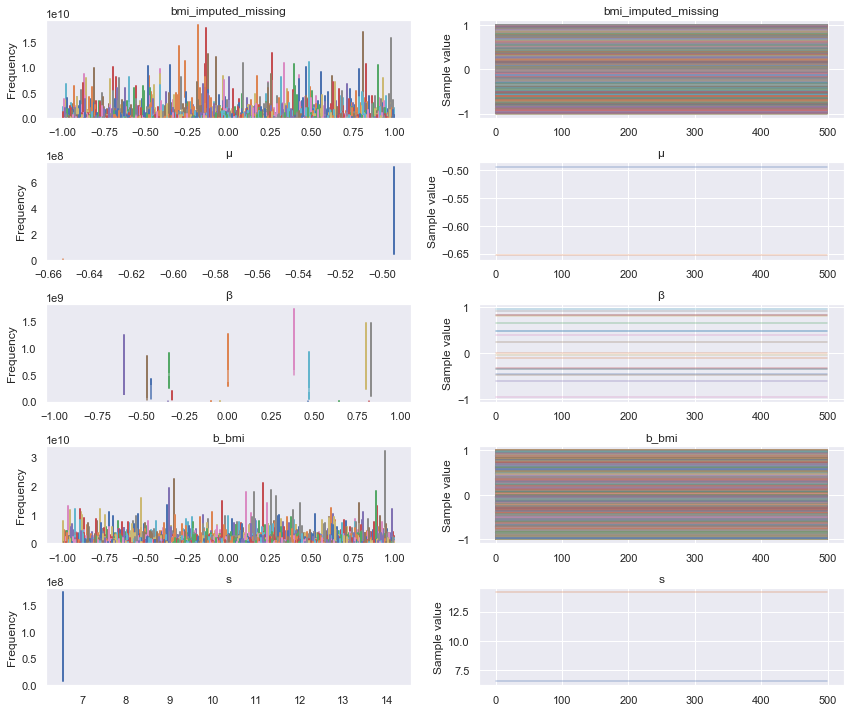

In [101]:
pm.traceplot(test_trace)

In [ ]:
np.argmax()

In [ ]:
def model_builder(data, fixed, random, outcome = 'readmit_30d', link = 'logistic', **kwargs):
    
    model = bm.Model(data)
    

In [96]:
import pymc3 as pm
import pymc3.glm as glm

formula = outcome + ' ~ ' + ' + '.join(demos + dx)
family = pm.glm.families.Binomial()

with pm.Model() as model:
    glm.GLM.from_formula(formula,train_red,family = family)

    start = pm.find_MAP()
    
    trace = pm.sample(500, start=start)

logp = -6,786.1, ||grad|| = 6.3336: 100%|██████████| 104/104 [00:00<00:00, 378.64it/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [icd_dx_symptoms, icd_dx_skin, icd_dx_respiratory, icd_dx_perinatal, icd_dx_obstetric, icd_dx_nervous, icd_dx_neoplasm, icd_dx_muscskel, icd_dx_mental, icd_dx_injury, icd_dx_infection, icd_dx_gu, icd_dx_external, icd_dx_endocrine, icd_dx_digestive, icd_dx_congenital, icd_dx_circulatory, icd_dx_blood, sex, age, Intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [01:01<00:00, 32.60draws/s]


In [92]:
# for RV in model.basic_RVs:
#     print(RV.name, RV.logp(model.test_point))

model.check_test_point()

Intercept                0.00
age                     -7.83
sex                     -7.83
icd_dx_blood            -7.83
icd_dx_circulatory      -7.83
icd_dx_congenital       -7.83
icd_dx_digestive        -7.83
icd_dx_endocrine        -7.83
icd_dx_external         -7.83
icd_dx_gu               -7.83
icd_dx_infection        -7.83
icd_dx_injury           -7.83
icd_dx_mental           -7.83
icd_dx_muscskel         -7.83
icd_dx_neoplasm         -7.83
icd_dx_nervous          -7.83
icd_dx_obstetric        -7.83
icd_dx_perinatal        -7.83
icd_dx_respiratory      -7.83
icd_dx_skin             -7.83
icd_dx_symptoms         -7.83
y                    -7951.09
Name: Log-probability of test_point, dtype: float64

In [88]:
model.logp(model.test_point)

array(-8718.1073018)

In [82]:
approx = pm.fit(n=10000, method='advi', model=model,
        obj_optimizer=pm.adagrad_window(learning_rate=2e-4))

In [154]:
# plt.rcParams['figure.figsize'] = [7,4]

# note: the following function is very brittle because it relies on the model_descs dictionary to be correctly defined
# & the trace names to be invariant

def mult_energyplot(traces = [simple_trace, visit_trace, dx_trace, labvar_trace, extended_trace, clinsignif_trace, full_trace]):
    
    from math import ceil
    
    n_rows = ceil(len(traces)/2)
    fig, ax = plt.subplots(n_rows,2,figsize = [16,5*n_rows])

    for axis,trace in zip(ax.flatten(),traces):
        energyplot(trace, ax = axis)
        axis.set_title(label = 'Model: {mdesc}\nBFMI = {bfmi}'.format(mdesc = model_descs[trace], bfmi = bfmi(trace).round(3)))
    
    if len(traces) % 2:
        axis = ax.flatten()[len(ax.flatten())-1]
        axis.axis('off')

# fig, ax = plt.subplots(1,2,figsize = [14,5])
# energyplot(simple_trace, ax = ax[0]);
# ax[0].set_title(label = 'Model: age + sex + BMI + pregnancy status\nBFMI = {}'.format(bfmi(simple_trace).round(3)));
# energyplot(simple_trace, ax = ax[1]);
# ax[1].set_title(label = 'Model: age + sex + BMI + pregnancy status\nBFMI = {}'.format(bfmi(simple_trace).round(3)));

In [5]:
import pandas as pd
train = pd.read_csv('../data/train_imputed.csv')
valid = pd.read_csv('../data/valid_imputed.csv')
test = pd.read_csv('../data/test_imputed.csv')

In [6]:
train.sex = (train.sex == 'M')*1
test.sex = (test.sex == 'M')*1
valid.sex = (valid.sex == 'M')*1
train.drop('Unnamed: 0',axis=1, inplace = True)
test.drop('Unnamed: 0',axis=1, inplace = True)
valid.drop('Unnamed: 0',axis=1, inplace = True)

In [7]:
train

,stay_length,n_transfers,readmit_30d,sex,race,cpt_anesthesia,cpt_eval_manage,cpt_expired,cpt_medicine,cpt_modifier,...,pregnancy_indicator_last,lab_systolic_median,lab_diastolic_median,lab_systolic_5p,lab_diastolic_5p,lab_systolic_95p,lab_diastolic_95p,lab_systolic_std,lab_diastolic_std,age
0,4,2,0,0,W,0,6,4,16,9,...,0.000000,140.000000,58.000000,107.000000,44.000000,186.000000,77.000000,20.263715,9.868120,57.385352
1,3,3,1,0,W,0,2,1,16,15,...,0.000000,121.000000,61.000000,106.000000,50.000000,146.000000,74.000000,12.518349,8.314473,57.867214
2,1,1,0,0,W,0,3,0,7,4,...,0.000000,131.000000,60.000000,108.000000,42.000000,188.000000,82.000000,25.989675,10.976472,57.935661
3,4,2,0,0,W,0,6,1,4,8,...,0.000000,151.000000,74.000000,116.000000,59.900000,165.000000,88.000000,15.661763,7.936733,58.428474
4,1,1,0,0,W,0,1,1,2,3,...,0.000000,134.000000,66.000000,122.000000,56.000000,158.000000,88.000000,11.855141,11.269165,58.559890
5,1,1,0,0,W,0,2,0,1,10,...,0.000000,140.000000,52.000000,120.000000,42.000000,176.000000,83.000000,18.407025,12.982164,61.103354
6,12,4,0,0,W,0,17,2,30,43,...,0.000000,144.000000,63.000000,106.000000,46.000000,175.000000,81.000000,20.383194,11.013734,61.393566
7,4,1,0,0,W,0,6,0,2,12,...,0.000000,143.000000,63.000000,120.950000,52.700000,176.000000,84.000000,16.881713,9.055357,62.672142
8,7,1,0,0,W,0,6,5,10,25,...,0.000711,149.000000,55.000000,117.000000,41.000000,170.000000,75.000000,16.280034,10.192773,62.986995
9,3,2,0,0,W,0,5,1,4,4,...,0.000000,131.000000,59.000000,113.000000,50.000000,150.000000,69.000000,11.896098,6.036469,65.152635


In [8]:
# id_vars = list(df.columns[0:3]) + ['total_encounters','group','dob','dod']
meds = list(train.columns[train.columns.str.contains('med_')])
cpts = list(train.columns[train.columns.str.contains('cpt_')])
dx = list(train.columns[train.columns.str.contains('icd_dx')])
labs = list(train.columns[train.columns.str.contains('lab_')])
bmi = list(train.columns[train.columns.str.contains('bmi|pregnancy')])
demos = ['age','sex']
outcomes = ['readmit_time','readmit_30d']
visit = cpts + ['n_transfers','stay_length','icd_proc','icd_visit']
final_var = demos + bmi + dx + labs + visit # drop meds; can't use them right off the bat

In [9]:
# select various different lab measures -- using all of them is redundant
labs_median = list(train.columns[train.columns.str.contains('lab_.*_median')])
labs_last = list(train.columns[train.columns.str.contains('lab_.*_last')]) + ['lab_systolic_median','lab_diastolic_median']
labs_extremes = list(train.columns[train.columns.str.contains('lab_.*5p')])
labs_var = list(train.columns[train.columns.str.contains('lab_.*_std')]) # redundancy analysis suggests this contains the most information not included in other variables

In [16]:
train[labs_var].isna().describe()

,lab_an.gap_std,lab_bun_std,lab_co2_std,lab_ca_std,lab_cl_std,lab_creat_std,lab_glubed_std,lab_gluc_std,lab_hgb_std,lab_k_std,...,lab_mchc_std,lab_mcv_std,lab_na_std,lab_pcv_std,lab_plt.ct_std,lab_rbc_std,lab_rdw_std,lab_wbc_std,lab_systolic_std,lab_diastolic_std
count,12912,12912,12912,12912,12912,12912,12912,12912,12912,12912,...,12912,12912,12912,12912,12912,12912,12912,12912,12912,12912
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,12912,12912,12912,12912,12912,12912,12912,12912,12912,12912,...,12912,12912,12912,12912,12912,12912,12912,12912,12912,12912
